# DeZero with GPU

구글 콜랩을 이용하면 DeZero를 GPU에서 구동해볼 수 있습니다(구글 콜랩에서 GPU를 무료로 이용할 수 있습니다). 이제부터 DeZero에서 간단한 계산을 CPU와 GPU 양쪽에서 실행해보며, GPU가 속도를 얼마나 개선해주는지 살펴보겠습니다.

# DeZero 설치하기

먼저 DeZero를 설치합니다. DeZero는 [PyPI](https://pypi.org/project/dezero/)에 등록되어 있으므로 pip install dezero 명령으로 설치할 수 있습니다.

In [ ]:
pip install dezero

설치가 완료되면 이어서 DeZero에서 GPU를 사용할 수 있는지 확인해봅니다.

In [1]:
import dezero
dezero.cuda.gpu_enable

/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/Scratch3/dezero/datasets.py:235: SyntaxWarning: "is" with a literal. Did you mean "=="?
  return fine_labels if label_type is 'fine' else coarse_labels


False

True가 나오면 GPU를 사용할 수 있는 상태입니다.

False가 뜨면 구글 콜랩에서 GPU 설정을 손봐줘야 합니다. 다음 순서로 진행합니다.

* ‘런타임’ 메뉴에서 ‘런타임 유형 변경’을 선택합니다.
* ‘하드웨어 가속기’ 드롭다운 메뉴에서 ‘GPU’를 선택합니다.
* ‘저장’ 버튼을 눌러 설정을 완료합니다.

# Train MNIST with CPU
이어서 DeZero에서 MNIST를 학습해보겠습니다.
우선은 CPU로 실행해보죠.

/Users/chohi/project/ai/DeepLearningDeepen/DeepLearningAdv/Scratch3/dezero/datasets.py:235: SyntaxWarning: "is" with a literal. Did you mean "=="?
  return fine_labels if label_type is 'fine' else coarse_labels


epoch: 1, loss: 1.9098, time: 3.5204[sec]
epoch: 2, loss: 1.2765, time: 2.8532[sec]
epoch: 3, loss: 0.9208, time: 2.9086[sec]
epoch: 4, loss: 0.7384, time: 2.4325[sec]
epoch: 5, loss: 0.6348, time: 2.5199[sec]
epoch: 6, loss: 0.5689, time: 2.4968[sec]
epoch: 7, loss: 0.5235, time: 2.4385[sec]
epoch: 8, loss: 0.4906, time: 2.4394[sec]
epoch: 9, loss: 0.4653, time: 2.4339[sec]
epoch: 10, loss: 0.4455, time: 2.5281[sec]
epoch: 11, loss: 0.4293, time: 2.4563[sec]
epoch: 12, loss: 0.4162, time: 2.4835[sec]
epoch: 13, loss: 0.4051, time: 2.4487[sec]
epoch: 14, loss: 0.3955, time: 2.4697[sec]
epoch: 15, loss: 0.3874, time: 2.4608[sec]
epoch: 16, loss: 0.3802, time: 2.4330[sec]
epoch: 17, loss: 0.3739, time: 2.4420[sec]
epoch: 18, loss: 0.3682, time: 2.6461[sec]
epoch: 19, loss: 0.3630, time: 2.4922[sec]
epoch: 20, loss: 0.3585, time: 2.5800[sec]
epoch: 21, loss: 0.3543, time: 2.5651[sec]
epoch: 22, loss: 0.3505, time: 2.7456[sec]
epoch: 23, loss: 0.3470, time: 3.1294[sec]
epoch: 24, loss: 0.3

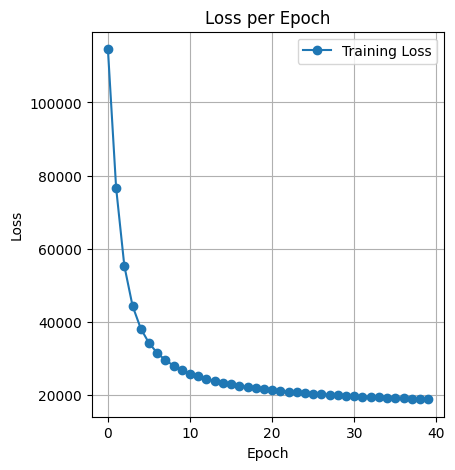

In [1]:
import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP
from dezero.datasets import MNIST
import matplotlib.pyplot as plt

max_epoch = 40
batch_size = 100
cpu_times = []

#train_set = dezero.datasets.MNIST(train=True)
train_set = MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

epochs = []
losses = []
for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    cpu_times.append(elapsed_time)
    epochs.append(epoch)
    losses.append(sum_loss)
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))



# Loss 플롯
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', label='Training Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()


# Train MNIST on GPU
다음은 GPU를 사용해볼 차례입니다.

In [4]:
gpu_times = []

# GPU mode
train_loader.to_gpu()
model.to_gpu()

for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    gpu_times.append(elapsed_time)
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

Exception: CuPy cannot be loaded. Install CuPy!

마지막으로 참고삼아 CPU와 GPU의 속도를 비교해봅니다.

In [5]:
cpu_avg_time = sum(cpu_times) / len(cpu_times)
gpu_avg_time = sum(gpu_times) / len(gpu_times)

print('CPU: {:.2f}[sec]'.format(cpu_avg_time))
print('GPU: {:.2f}[sec]'.format(gpu_avg_time))
print('GPU speedup over CPU: {:.1f}x'.format(cpu_avg_time/gpu_avg_time))

ZeroDivisionError: division by zero